<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/09_LSTM_emotion_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00


In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [3]:
from datasets import load_dataset
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions['train']['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

In [5]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
vocab_size = AutoConfig.from_pretrained(model_ckpt).vocab_size

vocab_size

30522

In [6]:
max([len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])

66

In [7]:
text_length = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=text_length,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=text_length,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

In [8]:
lstm_model = models.Sequential(name='LSTM_classifier')
lstm_model.add(layers.Embedding(vocab_size, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM_cell1'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.LSTM(256, return_sequences=False, name='LSTM_cell2'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(1024, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))
lstm_model.summary()

Model: "LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell1 (LSTM)           (None, None, 512)         2099200   
                                                                 
 dropout1 (Dropout)          (None, None, 512)         0         
                                                                 
 LSTM_cell2 (LSTM)           (None, 256)               787456    
                                                                 
 dropout2 (Dropout)          (None, 256)               0         
                                                                 
 feedforward (Dense)         (None, 1024)              263168    
                                                                 
 dropout3 (Dropout)          (None, 1024)          

In [9]:
lstm_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['acc'])

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=16, epochs=3)

Epoch 1/3
1000/1000 [==============================] - 76s 62ms/step - loss: 1.5921 - acc: 0.3236 - val_loss: 1.6005 - val_acc: 0.3520
Epoch 2/3
1000/1000 [==============================] - 36s 36ms/step - loss: 1.5883 - acc: 0.3235 - val_loss: 1.5856 - val_acc: 0.3520
Epoch 3/3
1000/1000 [==============================] - 32s 32ms/step - loss: 1.5828 - acc: 0.3300 - val_loss: 1.5885 - val_acc: 0.3520
CPU times: user 1min 56s, sys: 3.94 s, total: 2min
Wall time: 2min 23s


In [11]:
lstm_model = models.Sequential(name='Bidirectional_LSTM_classifier')
lstm_model.add(layers.Embedding(vocab_size, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True, name='LSTM_cell1')))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=False, name='LSTM_cell2')))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(1024, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))
lstm_model.summary()

Model: "Bidirectional_LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 dropout1 (Dropout)          (None, None, 1024)        0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 feedforward (Dense)         (None, 1

In [12]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

In [13]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=16, epochs=8)

Epoch 1/8
1000/1000 [==============================] - 91s 84ms/step - loss: 1.3277 - acc: 0.4600 - val_loss: 0.7291 - val_acc: 0.7265
Epoch 2/8
1000/1000 [==============================] - 64s 64ms/step - loss: 0.4901 - acc: 0.8181 - val_loss: 0.4153 - val_acc: 0.8505
Epoch 3/8
1000/1000 [==============================] - 62s 62ms/step - loss: 0.2510 - acc: 0.9097 - val_loss: 0.3497 - val_acc: 0.8770
Epoch 4/8
1000/1000 [==============================] - 62s 62ms/step - loss: 0.1593 - acc: 0.9461 - val_loss: 0.4045 - val_acc: 0.8815
Epoch 5/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.1252 - acc: 0.9567 - val_loss: 0.3899 - val_acc: 0.8870
Epoch 6/8
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0976 - acc: 0.9685 - val_loss: 0.3987 - val_acc: 0.8935
Epoch 7/8
1000/1000 [==============================] - 62s 62ms/step - loss: 0.0729 - acc: 0.9761 - val_loss: 0.3627 - val_acc: 0.9010
Epoch 8/8
1000/1000 [==============================] - 

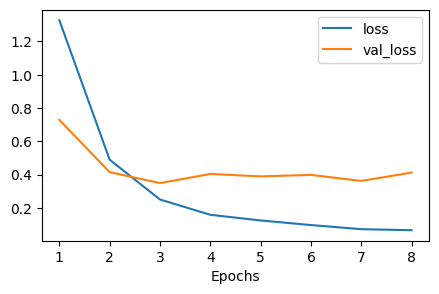

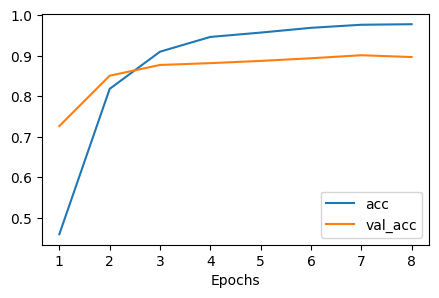

In [14]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

In [15]:
predictions = lstm_model.predict(test_text, verbose=0)

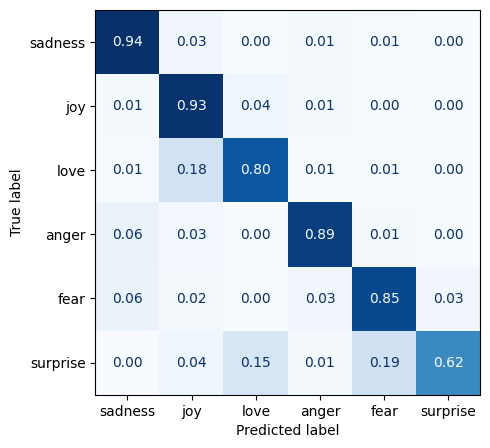

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

In [17]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=len(train_text[0]),
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = lstm_model.predict(input_ids, verbose=0)

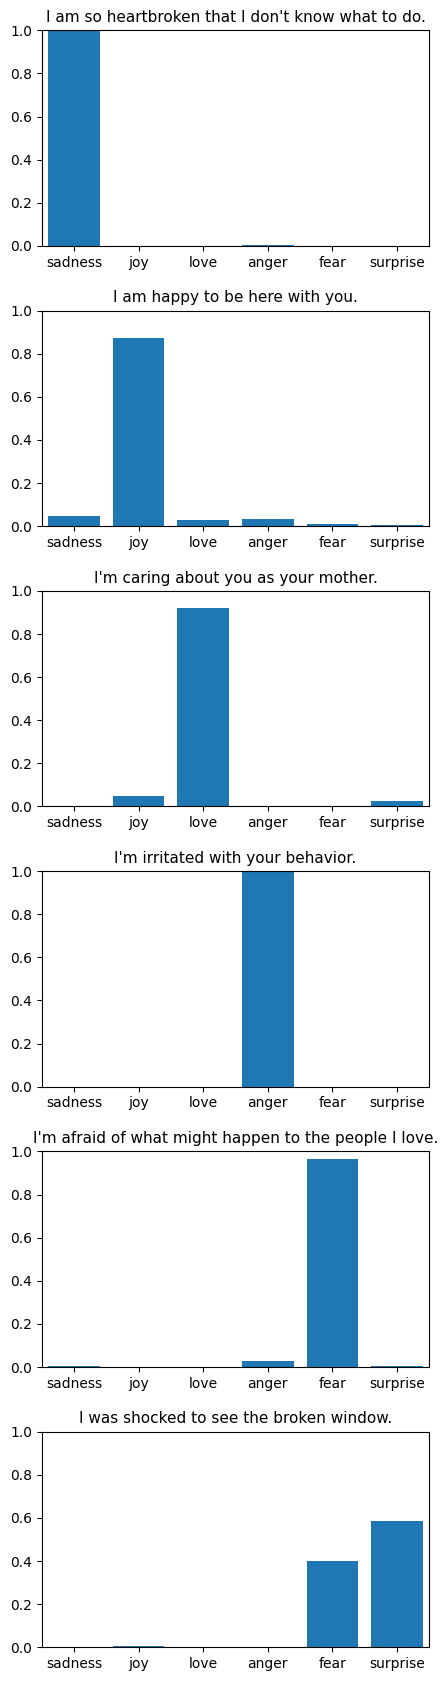

In [18]:
n = len(predictions)
fig = plt.figure(figsize=(5, 3.5 * n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')